MAX_EXCESS:  3


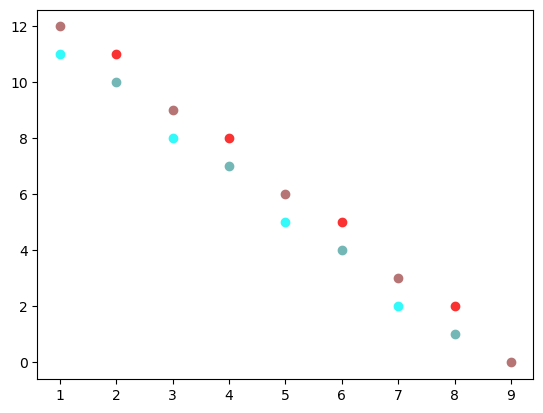

unmarked_components shape:
vertices
0     2
1    20
2    35
3    27
4     8
dtype: int64
blowup_components shape:
excess  g  odd  
-1      0  True      1
0       0  False     3
1       0  False     8
        1  False     2
2       0  False    19
           True      2
        1  False     1
3       0  False    55
           True      8
        1  False     4
           True      3
dtype: int64
relations2_groups size: 
excess  g
1       0     1
2       0     3
        1     1
3       0    10
        1     4
dtype: int64
blowup_components_basis size: 
excess  g  odd  
0       0  False     2
1       0  False     6
        1  False     1
2       0  False    15
3       0  False    44
        1  False     1
dtype: int64
blowups shape:
excess  partition
1       (1,)          3
2       (1, 1)       12
        (2,)          8
3       (1, 1, 1)    24
        (1, 2)       53
        (3,)         30
dtype: int64


In [13]:
%run MBELLI_Main.ipynb

In [ ]:
blowups_complete = pd.DataFrame(columns=['excess','partition','comp_ID_set','unmarkedComp_ID_set','A2Comp_ID_set','crossType','g','n','vertices','edges','graph','oj_hairs','tripods','eps'])
# Generate all (unordered) completions of the collections in blowups by means of appending the excess 0 uncrossed blown up components
# this task is grouped by excess and the possible (g,n) pairs corresponding to the excess
# the pair (g,n) determines uniquely which and how many excess 0 components must be appended to obtain a (g,n)-graph when they are glued to the special vertex
fails = pd.DataFrame(columns=['excess','g','n','graph'])
for blowup in get_blowups().itertuples():
    #fill in the dataframe a row for every pair (g,n) obtainable with these positive-excess components
    for (g,n) in gn_table[blowup.excess]:
        # the evenness condition is actually superfluous if the components have been generated right
        if g>=blowup.g and n>=blowup.n and (g-blowup.g)%2==0:
            oj_hairs = n-blowup.n
            tripods = ((g-blowup.g)/2)
            if 11==3*tripods+blowup.graph.ome+oj_hairs:
                components = [OJ_HAIR for x in range(oj_hairs)] + [TRIPOD for x in range(tripods)]
                components = components + list(blowup.graph.components)
                comp_ID_set = [C.ID for C in components]
                comp_ID_set.sort()
                comp_ID_set = tuple(comp_ID_set)
                unmarkedComp_ID_set = [C.unmarkedComponent.ID for C in components]
                unmarkedComp_ID_set.sort()
                unmarkedComp_ID_set = tuple(unmarkedComp_ID_set)
                A2Comp_ID_set=None
                if blowup.crossType=='A2':
                    A2Comp_ID_set = [C.ID for C in components if not C.crossed] + [C.ID for C in blowup.graph.crossedComponent.crossTypeA2_blowupComponents]
                    A2Comp_ID_set.sort()
                    A2Comp_ID_set = tuple(A2Comp_ID_set)
                G = BlowUpGraph(components)
                blowups_complete.loc[len(blowups_complete)] = {'graph':G,'comp_ID_set':comp_ID_set,'unmarkedComp_ID_set':unmarkedComp_ID_set,'A2Comp_ID_set':A2Comp_ID_set,'crossType':blowup.crossType,'excess':blowup.excess,'partition':blowup.partition,'g':g,'n':n,'vertices':G.vertices,'edges':G.edges,'oj_hairs':oj_hairs,'tripods':tripods,'eps':G.eps}
        else: fails.loc[len(fails)] = {'excess':blowup.excess,'g':g,'n':n,'graph':blowup.graph}
blowups_complete.sort_values(by=['excess','g','n','edges','crossType','unmarkedComp_ID_set','A2Comp_ID_set'], inplace=True)
blowups_complete.reset_index(drop=True)
for row in blowups_complete.itertuples(): row.graph.ID = str(row.Index)
print("blowups_complete size: ")
print(blowups_complete.groupby(['excess','g','n']).size())
print("blowups completion fails: ")
print(fails.groupby(['excess','g','n']).size())
#print(blowups_complete.groupby(['excess','g','n','unmarkedComp_ID_set']).size())

blowups_complete size: 
excess  g  n 
1       2  10      1
        4  7       3
        6  4       3
        8  1       3
2       1  12      1
        3  9       6
        5  6      16
        7  3      20
        9  0      13
3       2  11      9
        4  8      40
        6  5      84
        8  2     106
dtype: int64
blowups completion fails: 
excess  g  n 
1       2  10     2
2       1  12    19
        3  9     14
        5  6      4
        9  0      7
3       2  11    98
        4  8     67
        6  5     23
        8  2      1
dtype: int64


In [ ]:
print(gn_table)

def get_blowups_complete(excess=None,partition=None,vertices=None,unmarkedComp_ID_set=None,crossType=None, g=None, n=None):
    frame = blowups_complete
    conditions = frame['g']>=0
    if crossType!=None:
        if crossType=='BB': conditions = conditions & (frame['crossType']=='B') | (frame['crossType']=='Birr')
        else: conditions = conditions & (frame['crossType']==crossType)
    if excess!=None: conditions = conditions & (frame['excess']==excess)
    if g!=None: conditions = conditions & (frame['g']==g)
    if n!=None: conditions = conditions & (frame['n']==n)
    if partition!=None: conditions = conditions & (frame['partition']==partition)
    if vertices!=None: conditions = conditions & (frame['vertices']==vertices)
    if unmarkedComp_ID_set!=None: conditions = conditions & (frame['unmarkedComp_ID_set']==unmarkedComp_ID_set)
    return frame[conditions]

for row in fails[(fails['g']==1) & (fails['n']==12)].itertuples():
    break
    row.graph.show()

for row in get_blowups_complete(partition=(2,),crossType=None).itertuples():
    break
    #print(row.A2Comp_ID_set)
    row.graph.show()
    #for C in row.graph.crossedComponent.crossTypeA2_blowupComponents: C.show()

In [16]:
relations11_groups = pd.DataFrame(columns=['excess','unmarkedComp_ID_set','g','n','vertices','edges','graphs','basis','group_length'])
# unmarkedComp_ID_set is the sorted tuple of IDs of each unmarked BlowUpComponent object that determines the relation11 group
# graphs is the list of BlowUpGraph objects in case B or Birr that have been generated from the unmarked components with IDs in unmarkedComp_ID_set. It is sorted descendingly w.r.t. the eps_nadd_factor of each BlowUpGraph object
# basis (and basis_ID_set) is a sublist of graphs which spans a basis through the weight 11 relations

for unmarkedComp_ID_set,group in get_blowups_complete(crossType='BB').groupby(['unmarkedComp_ID_set']):
    #for G in group['graph'].tolist(): print(G)
    if not (group['vertices']==group.iloc[int(0)].vertices).all(): raise ValueError('not all blowups in the relation 11 group have same properties')
    if not (group['g']==group.iloc[int(0)].g).all(): raise ValueError('not all blowups in the relation 11 group have same properties')
    if not (group['n']==group.iloc[int(0)].n).all(): raise ValueError('not all blowups in the relation 11 group have same properties')
    if not (group['edges']==group.iloc[int(0)].edges).all(): raise ValueError('not all blowups in the relation 11 group have same properties')
    graphs = group['graph'].tolist()
    graphs.sort(key=lambda G: G.eps_nadd_factor, reverse=True)
    relations11_groups.loc[len(relations11_groups)] = {'excess':group.iloc[int(0)].excess, 'g':group.iloc[int(0)].g ,'n':group.iloc[int(0)].n ,'unmarkedComp_ID_set':unmarkedComp_ID_set, 'vertices':group.iloc[int(0)].vertices, 'edges':group.iloc[int(0)].edges, 'graphs':graphs,'basis':[]}
relations11_groups['group_length'] = relations11_groups['graphs'].apply(lambda graphs:len(graphs))
relations11_groups.sort_values(['excess','g','edges','group_length','unmarkedComp_ID_set'],inplace=True)

# compute basis after applying weight 11 relations
# DONE MANUALLY
for row in relations11_groups.itertuples():
    if row.group_length==1: row.basis.extend(row.graphs)  
    elif row.graphs[0].eps==1: row.basis.extend(row.graphs[:-1]) # HEURISTIC, NOT CHECKED
    else: row.basis.extend(row.graphs) # PLACEHOLDER, WORKS FOR EXCESS=3 BC EVERY GROUP WITH EPS=2 HAS ONLY ONE GRAPH

print("relations11_groups size: ")
print(relations11_groups.groupby(['excess','g','n','group_length']).size())

relations11_groups size: 
excess  g  n   group_length
1       2  10  1                1
        4  7   1                2
        6  4   1                2
        8  1   1                2
2       3  9   1                3
        5  6   1                9
        7  3   1               11
        9  0   1                8
3       2  11  1                2
               2                1
        4  8   1               14
               2                1
               3                1
        6  5   1               37
               3                2
        8  2   1               50
               3                2
dtype: int64


In [ ]:
relations13_groups = pd.DataFrame(columns=['excess','A2Comp_ID_set','g','n','vertices','edges','graphs'])
# A2Comp_ID_set is the sorted tuple of IDs of each marked BlowUpComponent object that determines the relation13 group
# graphs is the list of BlowUpGraph objects in case A2 whose further blowup at the special vertex results in the marked components with IDs in A2Comp_ID_set.  It is sorted descendingly w.r.t. the eps_nadd_factor of each BlowUpGraph object, and ascendingly w.r.t. the amount o hairs on the crossed component.

for A2Comp_ID_set,group in get_blowups_complete(crossType='A2').groupby(['A2Comp_ID_set']):
    #for G in group['graph'].tolist(): print(G)
    if not (group['vertices']==group.iloc[int(0)].vertices).all(): raise ValueError('not all blowups in the relation 13 group have same properties')
    if not (group['g']==group.iloc[int(0)].g).all(): raise ValueError('not all blowups in the relation 13 group have same properties')
    if not (group['n']==group.iloc[int(0)].n).all(): raise ValueError('not all blowups in the relation 13 group have same properties')
    if not (group['edges']==group.iloc[int(0)].edges).all(): raise ValueError('not all blowups in the relation 13 group have same properties')
    graphs = group['graph'].tolist()
    graphs.sort(key=lambda G: G.eps_nadd_factor, reverse=True)
    graphs.sort(key=lambda G: G.crossedComponent.nadd)
    relations13_groups.loc[len(relations13_groups)] = {'graphs':graphs, 'excess':group.iloc[int(0)].excess, 'g':group.iloc[int(0)].g ,'n':group.iloc[int(0)].n ,'A2Comp_ID_set':A2Comp_ID_set, 'vertices':group.iloc[int(0)].vertices, 'edges':group.iloc[int(0)].edges}

# compute basis after applying weight 13 relations
# DONE MANUALLY
for row in relations11_groups.itertuples():
    if row.graphs[0].eps==0: row.basis.extend(row.graphs)  # here we have len(graphs)==1
    elif row.graphs[0].eps==1: row.basis.extend(row.graphs[:-1])
    else: row.basis.extend(row.graphs) # PLACEHOLDER, WORKS FOR EXCESS=3 BC EVERY GROUP WITH EPS=2 HAS ONLY ONE GRAPH

relations13_groups.sort_values(['excess','g','n','edges'],inplace=True)
relations13_groups['group_length'] = relations13_groups['graphs'].apply(lambda graphs:len(graphs))
relations13_groups.sort_values(['excess','g','edges','group_length','A2Comp_ID_set'],inplace=True)

print("relations13_groups size: ")
print(relations13_groups.groupby(['excess','g','n','group_length']).size())

relations13_groups size: 
excess  g  n   group_length
2       1  12  1               1
        3  9   2               1
        5  6   2               1
        7  3   2               1
3       2  11  2               2
        4  8   2               2
               4               2
        6  5   4               4
        8  2   3               1
               4               3
dtype: int64


In [18]:
for row in relations11_groups[relations11_groups['graphs'].apply(lambda graphs: len(graphs)>0 and ((graphs[0].g==6 and graphs[0].n==5) or True and graphs[0].excess==3) and graphs[0].eps>=1)].itertuples():
    break
    print(row.excess,row.g,row.n,row.edges,row.unmarkedComp_ID_set,f' basis length: {len(row.basis)}')
    for G in row.graphs: G.show()

for row in relations13_groups[relations13_groups['graphs'].apply(lambda graphs: len(graphs)>0 and graphs[0].g==8 and graphs[0].n==2 and graphs[0].eps>=0)].itertuples():
    break
    print(row.excess,row.g,row.n,row.edges,row.A2Comp_ID_set)
    for G in row.graphs: G.show()


gn_table:  [[(1, 11), (3, 8), (5, 5), (7, 2)], [(2, 10), (4, 7), (6, 4), (8, 1)], [(1, 12), (3, 9), (5, 6), (7, 3), (9, 0)], [(2, 11), (4, 8), (6, 5), (8, 2)]]
||||----  excess: 25   (g,n): (2,11)   size: 9 ------||||
----   (g,n): (2,11)   edges: 1    size: 5     ----
--   cross type A3     amount: 1   --


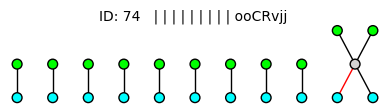

--   cross type A2      relation groups amount: 1  of which 0 of size 1--


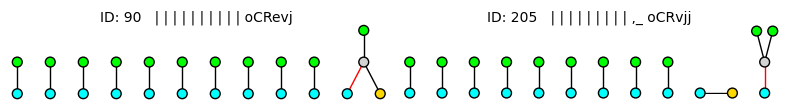

--   cross type B,Birr      relation groups amount: 1  of which 0 of size 1--


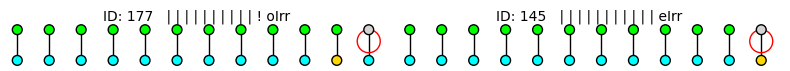

----   (g,n): (2,11)   edges: 2    size: 4     ----
--   cross type A2      relation groups amount: 1  of which 0 of size 1--


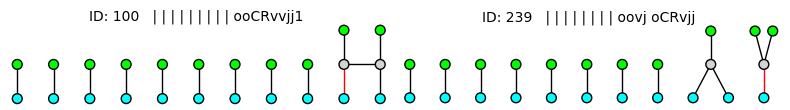

--   cross type B,Birr      relation groups amount: 2  of which 2 of size 1--


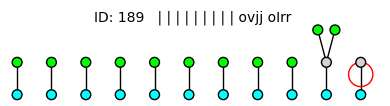

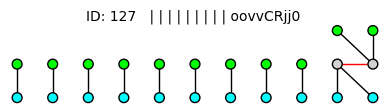

In [19]:
print('gn_table: ',gn_table)
def print_group(g,n):
    excess_group = blowups_complete[(blowups_complete['g']==g) & (blowups_complete['n']==n)]
    print(f'||||----  excess: {3*g-3+2*n}   (g,n): ({g},{n})   size: {len(excess_group)} ------||||')
    for edges,edge_group in excess_group.groupby('edges'):
        print(f'----   (g,n): ({g},{n})   edges: {edges}    size: {len(edge_group)}     ----')

        amount = (edge_group['crossType']=='A').sum()
        if amount!=0:  print(f"--   cross type A3     amount: {(edge_group['crossType']=='A').sum()}   --")
        for G in edge_group[edge_group['crossType']=='A'].itertuples():
            #break
            G.graph.show(title=True,graphics=True).show(figsize=[4,1.5])

        amount = ((relations13_groups['g']==g) & (relations13_groups['n']==n) & (relations13_groups['edges']==edges)).sum()
        amount1 = ((relations13_groups['g']==g) & (relations13_groups['n']==n) & (relations13_groups['edges']==edges) & (relations13_groups['group_length']==1)).sum()
        if amount!=0:  print(f"--   cross type A2      relation groups amount: {amount}  of which {amount1} of size 1--")
        for rel13group in relations13_groups[(relations13_groups['g']==g) & (relations13_groups['n']==n) & (relations13_groups['edges']==edges)].itertuples():
            #break
            graphics = []
            count=0
            for G in rel13group.graphs:
                if count%3==0: graphics.append([])
                graphics[-1].append(G.show(title=True,graphics=True))
                count+=1
            while count>3 and count%3!=0:
                graphics[-1].append(text(' ',(0,0),axes=False))
                count+=1
            graphics_array(graphics).show(figsize=[min(12,count*4),len(graphics)*1.5])

        amount = ((relations11_groups['g']==g) & (relations11_groups['n']==n) & (relations11_groups['edges']==edges)).sum()
        amount1 = ((relations11_groups['g']==g) & (relations11_groups['n']==n) & (relations11_groups['edges']==edges) & (relations11_groups['group_length']==1)).sum()
        if amount!=0: print(f"--   cross type B,Birr      relation groups amount: {amount}  of which {amount1} of size 1--")
        for rel11group in relations11_groups[(relations11_groups['g']==g) & (relations11_groups['n']==n) & (relations11_groups['edges']==edges)].itertuples():
            #break
            graphics = []
            count=0
            for G in rel11group.graphs:
                if count%3==0: graphics.append([])
                graphics[-1].append(G.show(title=True,graphics=True))
                count+=1
            while count>3 and count%3!=0:
                graphics[-1].append(text(' ',(0,0),axes=False))
                count+=1
            graphics_array(graphics).show(figsize=[min(12,count*4),len(graphics)*1.5])

for (excess,g,n),excess_group in blowups_complete.groupby(['excess','g','n']):
    break
    if excess==3:
        print_group(g,n)

print_group(2,11)